In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
from pymatgen.core import Structure
import json
import gzip
import re
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

### Try pymatgen volume prediction and linear regression

In [7]:
from pymatgen.analysis.structure_prediction.volume_predictor import DLSVolumePredictor

In [9]:
def get_structures(filename, ids=None):
    with gzip.open(Path(structure_dir, filename), 'r') as f:
        data = json.loads(f.read().decode())
        
        if ids is None:
            ids = data.keys()
            
        for key in tqdm(ids):
            if key in data:
                yield {'id': key, 'structure': Structure.from_dict(data[key])}        

In [11]:
structure_dir = Path('/projects/rlmolecule/jlaw/inputs/structures/')
calc_energy = pd.read_csv(Path(structure_dir, 'battery_relaxed_energies.csv'))

In [78]:
df_volunrelaxed = pd.DataFrame(get_structures('volrelax/battery_unrelaxed_vol_structures.json.gz'))
df_volrelaxed = pd.DataFrame(get_structures('volrelax/battery_relaxed_vol_structures.json.gz'))
df_volunrelaxed.head(1)

  0%|          | 0/30324 [00:00<?, ?it/s]

  0%|          | 0/30324 [00:00<?, ?it/s]

,id,structure
0,Zn1La3I2P3_sg189_icsd_076297_1,"[[1.40247399 2.42915575 0. ] La, [4.143..."


In [81]:
df_volrelaxed['vol'] = df_volrelaxed.structure.apply(lambda x: x.volume)
df_volrelaxed['num_sites'] = df_volrelaxed.structure.apply(lambda x: x.num_sites)
df_volrelaxed['vol_per_atom'] = df_volrelaxed.vol / df_volrelaxed.num_sites

<AxesSubplot:>

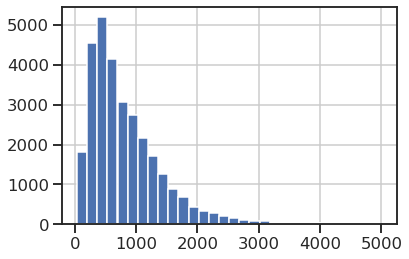

In [102]:
df_volrelaxed[df_volrelaxed.vol < 5000].vol.hist(bins=30)

In [103]:
df_volrelaxed.vol.min()

36.0859716208028

In [313]:
def predict_volume_from_struct(structure):
    structure = structure.copy()
    orig_volume = structure.volume
    
    # dist = structure.distance_matrix
    # min_dist = dist[np.triu(np.ones(dist.shape), k=1).astype(np.bool)].min()
    # scale_factor = (1 / min_dist)**3
    # structure.scale_lattice(orig_volume * scale_factor)
    try:
        pred_volume = volume_prediction.predict(structure)
        volume_factor = pred_volume / orig_volume
    except ValueError:
        pred_volume = None
        
    return pd.Series({
        'orig_volume': orig_volume,
        'pred_volume': pred_volume,
        # 'scale_factor': scale_factor,
        'pymatgen_factor': volume_factor,
    })

structure = df_volunrelaxed.structure.iloc[0].copy()
predict_volume_from_struct(structure)

orig_volume        173.776264
pred_volume        232.717183
pymatgen_factor      1.339177
dtype: float64

In [237]:
volume_prediction = DLSVolumePredictor()
predicted_volumes = df_volunrelaxed[df_volunrelaxed.id.isin(df.id)].set_index('id')\
                    .structure.progress_apply(predict_volume_from_struct)

  0%|          | 0/24675 [00:00<?, ?it/s]

/tmp/ipykernel_7802/2396671935.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_dist = dist[np.triu(np.ones(dist.shape), k=1).astype(np.bool)].min()


In [246]:
merged_data = df.set_index('id').join(predicted_volumes)
merged_data['true_vol'] = df_volrelaxed['vol']
merged_data['num_sites'] = df_volrelaxed['num_sites']
merged_data.rename({'pred_volume':'dls1.5_pred_volume'}, axis=1, inplace=True)

In [249]:
volume_prediction = DLSVolumePredictor(min_scaling=0.01, max_scaling=100.)
predicted_volumes = df_volunrelaxed[df_volunrelaxed.id.isin(df.id)].set_index('id')\
                    .structure.progress_apply(predict_volume_from_struct)

  0%|          | 0/24675 [00:00<?, ?it/s]

/tmp/ipykernel_7802/2396671935.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_dist = dist[np.triu(np.ones(dist.shape), k=1).astype(np.bool)].min()


In [254]:
merged_data['dls100_pred_volume'] = predicted_volumes['pred_volume']

In [255]:
merged_data.rename({'vol':'true_vol'}, axis=1, inplace=True)

In [278]:
# scale by the # sites
merged_data['true_vol_per_atom'] = merged_data['true_vol'] / merged_data['num_sites']
merged_data['orig_vol_per_atom'] = merged_data['orig_volume'] / merged_data['num_sites']
merged_data['dls1.5_pred_vol_per_atom'] = merged_data['dls1.5_pred_volume'] / merged_data['num_sites']
merged_data['dls100_pred_vol_per_atom'] = merged_data['dls100_pred_volume'] / merged_data['num_sites']

In [261]:
merged_data.head(2)

,comp_type,composition,energyperatom,orig_volume,dls1.5_pred_volume,scale_factor,pymatgen_factor,true_vol,num_sites,dls100_pred_volume,true_vol_per_atom,dls1.5_pred_vol_per_atom,dls100_pred_vol_per_atom
id,,,,,,,,,,,,,
K5Hg1I1N2_sg194_icsd_033805_2,_1_1_2_5,K5Hg1I1N2,-0.176,567.97195,851.957925,0.188923,1.5,1444.171646,36.0,3245.971944,40.115879,23.665498,90.165887
K5Hg1I1N2_sg26_icsd_059680_1,_1_1_2_5,K5Hg1I1N2,-2.092,238.03452,357.051780,0.151703,1.5,500.194366,18.0,543.300647,27.788576,19.836210,30.183369


In [ ]:
merged_data.plot.scatter(x='vol', y='pred_volume', s=1)

In [109]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [107]:
def dss_scatter(df, x, y, ax, xrange=None, yrange=None, xlabel='', ylabel=''):
    # xrange = (0, df[x].max()) if not xrange else xrange
    # yrange = (0, df[y].max()) if not yrange else yrange
    dsshow(df, ds.Point(x, y),
       ax=ax, shade_hook=dstf.dynspread, 
           cmap='Blues', norm='eq_hist', aspect='auto', 
           y_range=yrange, x_range=xrange)

    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
    # also compute the MAE and add it to the plot
    mae = mean_absolute_error(df.dropna()[x], df.dropna()[y])
    ax.text(1, 0.925, f'MAE: {mae:.1f} vol/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

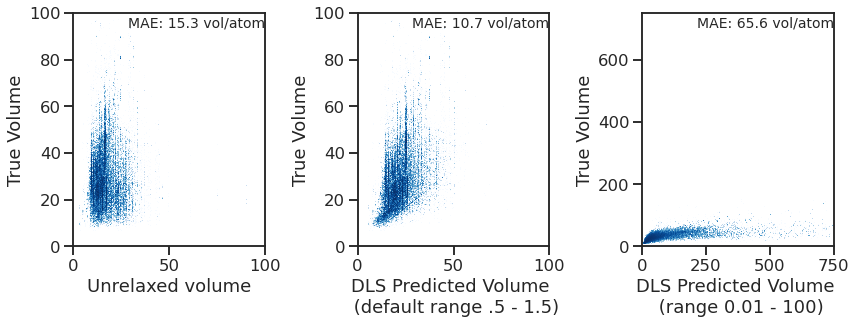

In [286]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(231, adjustable='box')
dss_scatter(merged_data,
            'orig_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,100), yrange=(0,100), 
            xlabel='Unrelaxed volume', 
            ylabel='True Volume')

ax = fig.add_subplot(232, adjustable='box')
dss_scatter(merged_data,
            'dls1.5_pred_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,100), yrange=(0,100), 
            xlabel='DLS Predicted Volume \n (default range .5 - 1.5)', 
            ylabel='True Volume')

ax = fig.add_subplot(233, adjustable='box')
dss_scatter(merged_data,
            'dls100_pred_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,750), yrange=(0,750), 
            xlabel='DLS Predicted Volume \n (range 0.01 - 100)', 
            ylabel='True Volume')

plt.tight_layout()

Text(0.5, 0, 'Volume scaling facter of \n unrelaxed vs DFT volume relaxation')

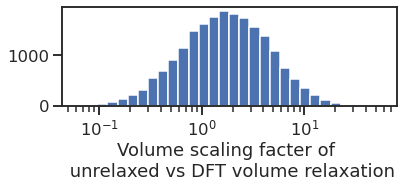

In [114]:
merged_data['dft_vol_scale'] = merged_data['vol'] / merged_data['orig_volume']
hist, bins = np.histogram(merged_data['dft_vol_scale'].dropna(), bins=30)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(merged_data['dft_vol_scale'], bins=logbins)
plt.xscale('log')
plt.xlabel("Volume scaling factor of \n unrelaxed vs DFT volume relaxation")

In [ ]:
merged_data.to_csv(Path(strc_dir, "dls_vol_pred.csv"))

In [ ]:
len(predicted_volumes.isna())

### Retry with ICSD structures to make sure I can recreate peter's results

In [122]:
icsd_pred_volumes = icsd_strcs.structure.progress_apply(predict_volume_from_scaled_struct)

  0%|          | 0/16445 [00:00<?, ?it/s]

/tmp/ipykernel_7802/2396671935.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_dist = dist[np.triu(np.ones(dist.shape), k=1).astype(np.bool)].min()


## Volume prediction using linear model
For example: Li3N1: 3 * average Li volume + 1 * average N volume

In [123]:
icsd_structures = icsd_strcs

In [124]:
icsd_structures['true_volume'] = icsd_structures.structure.apply(lambda x: x.volume)
icsd_structures['num_sites'] = icsd_structures.structure.apply(lambda x: x.num_sites)

In [157]:
from collections import Counter

site_counts = icsd_structures.structure.progress_apply(
    lambda structure: pd.Series(Counter((str(site.specie.element) for site in structure.sites)))
).fillna(0)

output_bias = np.linalg.lstsq(site_counts, icsd_structures["true_volume"], rcond=None)

  0%|          | 0/16445 [00:00<?, ?it/s]

In [158]:
site_counts.shape

(16445, 60)

In [156]:
output_bias[0].shape

(60,)

In [128]:
icsd_structures['linear_pred_vol'] = site_counts @ output_bias[0]

In [129]:
icsd_structures['true_volume_per_atom'] = icsd_structures['true_volume'] / icsd_structures['num_sites']
icsd_structures['linear_pred_vol_per_atom'] = icsd_structures['linear_pred_vol'] / icsd_structures['num_sites']

Text(0, 0.5, 'True Volume')

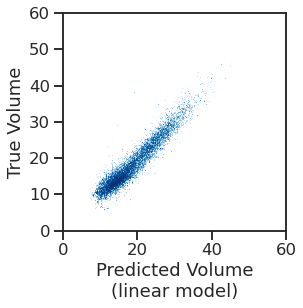

In [130]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, adjustable='box')

dsshow(icsd_structures, ds.Point('linear_pred_vol_per_atom', 'true_volume_per_atom'),
       ax=ax, shade_hook=dstf.dynspread, cmap='Blues', norm='eq_hist', aspect='auto', y_range=(0, 60), x_range=(0, 60))

ax.set_xlabel('Predicted Volume\n(linear model)')
ax.set_ylabel('True Volume')

In [131]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(icsd_structures['linear_pred_vol_per_atom'], icsd_structures['true_volume_per_atom'])

1.9192559089358436

### repeat with unrelaxed structures

In [173]:
site_bias = pd.read_csv("/projects/rlmolecule/pstjohn/crystal_inputs/site_volumes_from_icsd.csv",
                       index_col=0, squeeze=True)
site_bias.head(2)

La    26.984444
Zn    15.090608
Name: 0, dtype: float64

In [171]:
def make_linear_pred(df_structures, site_bias):
    site_counts = df_volunrelaxed.structure.progress_apply(
        lambda structure: pd.Series(Counter((str(site.specie) for site in structure.sites)))
    ).fillna(0)
    curr_site_bias = site_bias[site_bias.index.isin(site_counts.columns)]
    
    return site_counts @ curr_site_bias

In [287]:
df_volunrelaxed['linear_pred_vol'] = make_linear_pred(df_volunrelaxed, site_bias)

  0%|          | 0/30324 [00:00<?, ?it/s]

In [290]:
merged_data['linear_pred_vol'] = df_volunrelaxed.set_index('id')['linear_pred_vol']
merged_data['linear_pred_vol_per_atom'] = merged_data['linear_pred_vol'] / merged_data['num_sites']

In [291]:
merged_data.head(2)

,comp_type,composition,energyperatom,orig_volume,dls1.5_pred_volume,scale_factor,pymatgen_factor,true_vol,num_sites,dls100_pred_volume,true_vol_per_atom,dls1.5_pred_vol_per_atom,dls100_pred_vol_per_atom,orig_vol_per_atom,linear_pred_vol,linear_pred_vol_per_atom
id,,,,,,,,,,,,,,,,
K5Hg1I1N2_sg194_icsd_033805_2,_1_1_2_5,K5Hg1I1N2,-0.176,567.97195,851.957925,0.188923,1.5,1444.171646,36.0,3245.971944,40.115879,23.665498,90.165887,15.776999,1073.307416,29.814095
K5Hg1I1N2_sg26_icsd_059680_1,_1_1_2_5,K5Hg1I1N2,-2.092,238.03452,357.051780,0.151703,1.5,500.194366,18.0,543.300647,27.788576,19.836210,30.183369,13.224140,536.653708,29.814095


Text(0.5, 0, 'Volume scaling facter of \n DFT volume relaxed  vs linear volume prediction')

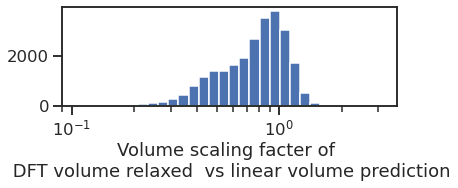

In [180]:
merged_data['linear_vol_scale'] = merged_data['linear_pred_vol'] / merged_data['vol']
hist, bins = np.histogram(merged_data['linear_vol_scale'].dropna(), bins=30)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(merged_data['linear_vol_scale'], bins=logbins)
plt.xscale('log')
# merged_data['dft_vol_scale'].hist(bins=30)
# plt.xscale("log")
plt.xlabel("Volume scaling factor of \n DFT volume relaxed  vs linear volume prediction")

In [293]:
merged_data2 = merged_data.dropna()
subset = merged_data2.linear_pred_vol < 1E06
from sklearn.metrics import mean_absolute_error
mean_absolute_error(
    merged_data2[subset]['linear_pred_vol'] / merged_data2[subset]['num_sites'],
    merged_data2[subset]['true_vol'] / merged_data2[subset]['num_sites'])

9.8735938269177

### Try using the DLS scalar after applying the linear volume prediction

In [296]:
def predict_volume_from_scaled_struct(row):
    structure, vol_pred = row
    structure = structure.copy()
    
    structure.scale_lattice(vol_pred)
    orig_volume = structure.volume
    try:
        pred_volume = volume_prediction.predict(structure)
        volume_factor = pred_volume / orig_volume
    except ValueError:
        pred_volume = None
        
    return pd.Series({
        'orig_volume': orig_volume,
        'pred_volume': pred_volume,
        'pymatgen_factor': volume_factor,
    })

In [297]:
volume_prediction = DLSVolumePredictor()
predicted_volumes = df_volunrelaxed[df_volunrelaxed.id.isin(df.id)].set_index('id')[['structure', 'linear_pred_vol']] \
                     .progress_apply(predict_volume_from_scaled_struct, axis=1)

  0%|          | 0/24675 [00:00<?, ?it/s]

In [304]:
merged_data['linear_dls1.5_pred_vol'] = predicted_volumes['pred_volume']
merged_data['linear_dls1.5_pred_vol_per_atom'] = merged_data['linear_dls1.5_pred_vol'] / merged_data['num_sites']

In [320]:
volume_prediction = DLSVolumePredictor(cutoff=8, min_scaling=.25, max_scaling=2)
predicted_volumes = df_volunrelaxed[df_volunrelaxed.id.isin(df.id)].set_index('id')[['structure', 'linear_pred_vol']] \
                     .progress_apply(predict_volume_from_scaled_struct, axis=1)

  0%|          | 0/24675 [00:00<?, ?it/s]

In [321]:
merged_data['linear_dls2_pred_vol'] = predicted_volumes['pred_volume']
merged_data['linear_dls2_pred_vol_per_atom'] = merged_data['linear_dls2_pred_vol'] / merged_data['num_sites']

In [307]:
volume_prediction = DLSVolumePredictor(cutoff=6, min_scaling=.25, max_scaling=4)
predicted_volumes = df_volunrelaxed[df_volunrelaxed.id.isin(df.id)].set_index('id')[['structure', 'linear_pred_vol']] \
                     .progress_apply(predict_volume_from_scaled_struct, axis=1)

  0%|          | 0/24675 [00:00<?, ?it/s]

In [308]:
merged_data['linear_dls4_pred_vol'] = predicted_volumes['pred_volume']
merged_data['linear_dls4_pred_vol_per_atom'] = merged_data['linear_dls4_pred_vol'] / merged_data['num_sites']

In [314]:
volume_prediction = DLSVolumePredictor(cutoff=6, min_scaling=.25, max_scaling=4)
predicted_volumes = df_volunrelaxed[df_volunrelaxed.id.isin(df.id)].set_index('id').structure \
                     .progress_apply(predict_volume_from_struct)

  0%|          | 0/24675 [00:00<?, ?it/s]

In [315]:
merged_data['dls4_pred_vol'] = predicted_volumes['pred_volume']
merged_data['dls4_pred_vol_per_atom'] = merged_data['dls4_pred_vol'] / merged_data['num_sites']

/lustre/eaglefs/projects/rlmolecule/jlaw/envs/crystals_nfp0_3/lib/python3.8/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(
/lustre/eaglefs/projects/rlmolecule/jlaw/envs/crystals_nfp0_3/lib/python3.8/site-packages/datashader/mpl_ext.py:143: UserWarning: EqHistColorMapper warning: Histogram equalization did not converge.
  warnings.warn(


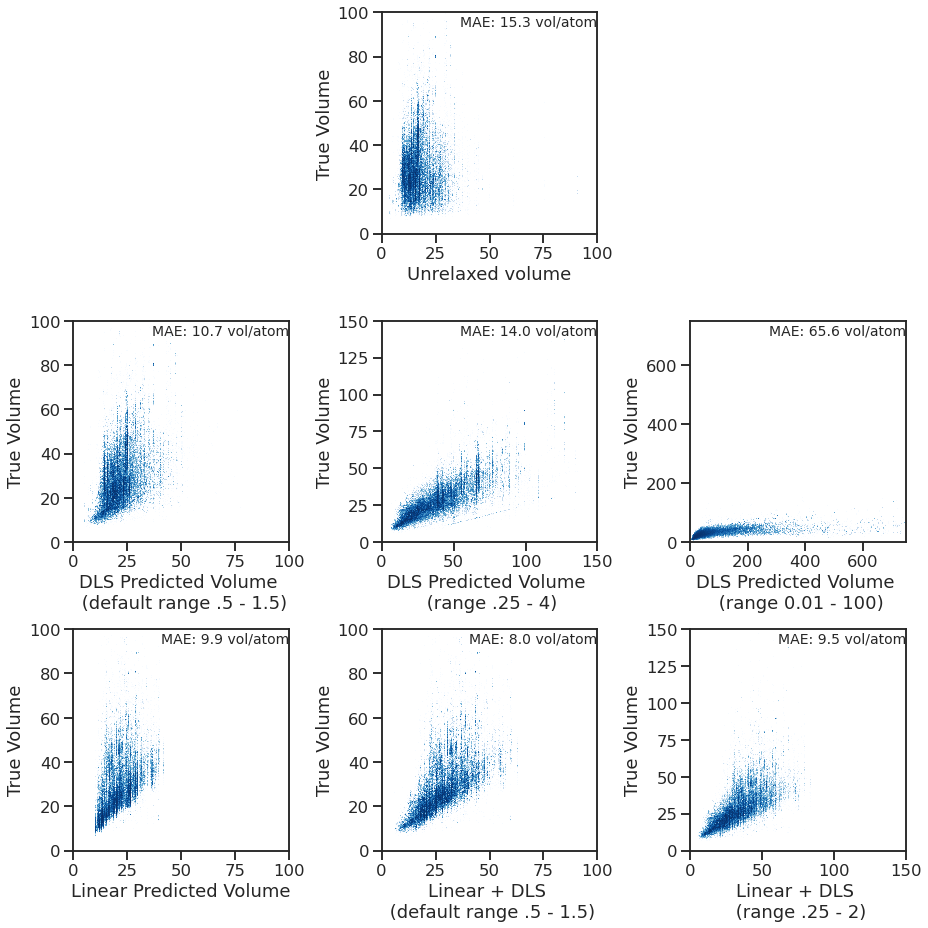

In [322]:
fig = plt.figure(figsize=(13,13))

ax = fig.add_subplot(332, adjustable='box')
dss_scatter(merged_data,
            'orig_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,100), yrange=(0,100), 
            xlabel='Unrelaxed volume', 
            ylabel='True Volume')

ax = fig.add_subplot(334, adjustable='box')
dss_scatter(merged_data,
            'dls1.5_pred_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,100), yrange=(0,100), 
            xlabel='DLS Predicted Volume \n (default range .5 - 1.5)', 
            ylabel='True Volume')

ax = fig.add_subplot(335, adjustable='box')
dss_scatter(merged_data,
            'dls4_pred_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,150), yrange=(0,150), 
            xlabel='DLS Predicted Volume \n (range .25 - 4)', 
            ylabel='True Volume')

ax = fig.add_subplot(336, adjustable='box')
dss_scatter(merged_data,
            'dls100_pred_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,750), yrange=(0,750), 
            xlabel='DLS Predicted Volume \n (range 0.01 - 100)', 
            ylabel='True Volume')

ax = fig.add_subplot(337, adjustable='box')
dss_scatter(merged_data,
            'linear_pred_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,100), yrange=(0,100), 
            xlabel='Linear Predicted Volume', 
            ylabel='True Volume')

ax = fig.add_subplot(338, adjustable='box')
dss_scatter(merged_data,
            'linear_dls1.5_pred_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,100), yrange=(0,100), 
            xlabel='Linear + DLS \n (default range .5 - 1.5)', 
            ylabel='True Volume')

ax = fig.add_subplot(339, adjustable='box')
dss_scatter(merged_data,
            'linear_dls2_pred_vol_per_atom', 
            'true_vol_per_atom',
            ax, 
            xrange=(0,150), yrange=(0,150), 
            xlabel='Linear + DLS \n (range .25 - 2)', 
            ylabel='True Volume')

plt.tight_layout()

In [323]:
merged_data['linear_dls1.5_pred_vol'].to_csv(Path(structure_dir, 'linear_dls1.5_predicted_volumes.csv'))

In [346]:
merged_data['dls1.5_pred_volume'].to_csv(Path(structure_dir, 'dls1.5_predicted_volumes.csv'))

### Scale factor comparisons

In [345]:
merged_data.head(2)

,comp_type,composition,energyperatom,orig_volume,dls1.5_pred_volume,scale_factor,pymatgen_factor,true_vol,num_sites,dls100_pred_volume,...,linear_dls1.5_vol_pred,linear_dls1.5_vol_pred_per_atom,linear_dls1.5_pred_vol,linear_dls1.5_pred_vol_per_atom,linear_dls4_pred_vol,linear_dls4_pred_vol_per_atom,dls4_pred_vol,dls4_pred_vol_per_atom,linear_dls2_pred_vol,linear_dls2_pred_vol_per_atom
id,,,,,,,,,,,,,,,,,,,,,
K5Hg1I1N2_sg194_icsd_033805_2,_1_1_2_5,K5Hg1I1N2,-0.176,567.97195,851.957925,0.188923,1.5,1444.171646,36.0,3245.971944,...,1609.961124,44.721142,1609.961124,44.721142,3245.971944,90.165887,2271.887801,63.107994,2146.614831,59.628190
K5Hg1I1N2_sg26_icsd_059680_1,_1_1_2_5,K5Hg1I1N2,-2.092,238.03452,357.051780,0.151703,1.5,500.194366,18.0,543.300647,...,543.300647,30.183369,543.300647,30.183369,543.300647,30.183369,543.300647,30.183369,543.300647,30.183369


In [346]:
merged_data['dls1.5_pred_volume'].to_csv(Path(structure_dir, 'dls1.5_predicted_volumes.csv'))

In [350]:
merged_data['dls4_pred_vol'].to_csv(Path(structure_dir, 'dls4_predicted_volumes.csv'))

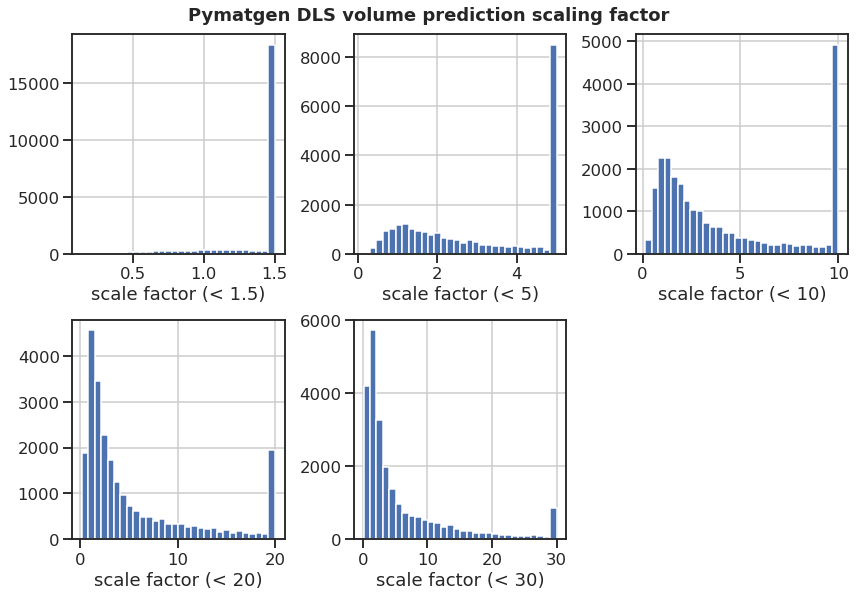

In [378]:
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = [ax for row_axes in axes for ax in row_axes]
for i, scale_cutoff in enumerate([1.5, 5, 10, 20, 30]):
    scale_factor = merged_data['dls100_pred_volume'] / merged_data['orig_volume']
    scale_factor[scale_factor > scale_cutoff] = scale_cutoff
    
    ax = axes[i]
    scale_factor.hist(bins=30, ax=ax)
    ax.set_xlabel(f"scale factor (< {scale_cutoff})")
    # plt.show()
    col = f"dls{scale_cutoff}_pred_vol"
    # merged_data[col] = merged_data['orig_volume'] * scale_factor
    # merged_data[col].to_csv(Path(structure_dir, f'volrelax/dls{scale_cutoff}_predicted_volumes.csv'))
axes[i+1].remove()
plt.tight_layout()
plt.suptitle("Pymatgen DLS volume prediction scaling factor", y=1.03, fontweight='bold', fontsize=18)
plt.show()

<AxesSubplot:>

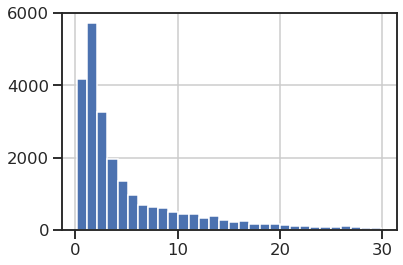

In [356]:
# scale_factor = merged_data['orig_volume'] / merged_data['dls4_pred_vol']
# scale_factor =  merged_data['dls4_pred_vol'] / merged_data['orig_volume']
scale_factor =  merged_data['dls100_pred_volume'] / merged_data['orig_volume']
scale_factor[scale_factor < 30].hist(bins=30)

In [348]:
merged_data['dls100_pred_volume'].to_csv(Path(structure_dir, 'dls100_predicted_volumes.csv'))

In [347]:
merged_data['linear_dls1.5_pred_vol'].to_csv(Path(structure_dir, 'linear_dls1.5_predicted_volumes.csv'))

In [324]:
merged_data['linear_dls1.5_pred_vol'].head(2)

id
K5Hg1I1N2_sg194_icsd_033805_2    1609.961124
K5Hg1I1N2_sg26_icsd_059680_1      543.300647
Name: linear_dls1.5_pred_vol, dtype: float64

In [333]:
merged_data['linear_dls1.5_pred_vol'].loc['K4F3Cl1_sg63_icsd_015139_1']

1074.2123373591696

In [336]:
len(merged_data.dropna())

24675

In [339]:
keys = set(merged_data['linear_dls1.5_pred_vol'].index)
len(keys)

24864

In [380]:
strcs = [
    'K4B1I4N1_sg215_icsd_414557_2',
    'K3P1_sg221_icsd_167837_1',
    'K3P1_sg166_icsd_028783_1',
    'K3P1_sg221_icsd_025596_1',
    'K3N1_sg221_icsd_167837_1',
    'Mg3Br3N1_sg223_icsd_611953_1',
]

In [382]:
merged_data.loc[strcs][['linear_dls1.5_pred_vol', 'true_vol']]

,linear_dls1.5_pred_vol,true_vol
id,,
K4B1I4N1_sg215_icsd_414557_2,513.859164,679.123624
K3P1_sg221_icsd_167837_1,186.025667,161.197020
K3P1_sg166_icsd_028783_1,185.941680,169.748027
K3P1_sg221_icsd_025596_1,186.025667,172.321440
K3N1_sg221_icsd_167837_1,116.177152,122.646428
Mg3Br3N1_sg223_icsd_611953_1,423.363604,343.561846
